In [1]:
from time_lstm import T1TimeLSTM, T2TimeLSTM
from dataset_delay_predictions import Dataset_Delay_Prediction, Dataset_Delay_Prediction_from_list, DatasetDelayPredictionStackOverflow
from time_dependant_representation import TimeDepMasking, TimeDepJointEmbedding
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Masking, Layer, LSTM
import os
import tensorflow as tf
import pickle
import pprint
from matplotlib import pyplot as plt

In [28]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y-%H%M%S")
print(dt_string)

now = 2020-02-20 23:12:59.165797
20-02-2020-231259


In [2]:
dataset_names = [
    '2019-10_11_12-dataset_delay_prediction',
    'stack-overflow-dataset'
]

In [3]:
dataset_name = dataset_names[1]
pickle_filename = dataset_name.replace('/', '-')
if os.path.exists(pickle_filename):
    print('Reading pickle file...')
    dataset = pickle.load(open(pickle_filename, 'rb'))

Reading pickle file...


In [4]:
training_set_length = int(4./5*len(dataset.full_features_log_dt))
print(training_set_length)

5306


In [5]:
training_set_length = dataset.training_set_length
print(training_set_length)
X_train = dataset.full_features_log_dt[:training_set_length]
seqlen = dataset.full_seqlen[:training_set_length]
y_train = np.array(dataset.next_event[:training_set_length])
print(y_train.shape)

test_set_length = len(dataset.full_features_log_dt) - training_set_length
X_test = dataset.full_features_log_dt[training_set_length:]
seqlen_test = dataset.full_seqlen[training_set_length:]
y_test = np.array(dataset.full_values[training_set_length:])
y_test = np.array(dataset.next_event[training_set_length:])
print(y_test.shape)

5306
(5306, 22)
(1327, 22)


In [6]:
y_all_timesteps = []
for x, y in zip(X_train, y_train):
    seq = [x_[:-2] for x_ in x[1:]] + [list(y)]
    y_all_timesteps.append(seq)

In [7]:
full_y_train = []
for x,y in zip(X_train, y_train):
    seq_of_event_to_predict = [x_[:-2] for x_ in x[1:]] + [y]
    full_y_train.append(seq_of_event_to_predict)

full_y_test = []
for x,y in zip(X_test, y_test):
    seq_of_event_to_predict = [x_[:-2] for x_ in x[1:]] + [y]
    full_y_test.append(seq_of_event_to_predict)

In [8]:
np_full_y_test = np.array(full_y_test)

In [9]:
np_full_y_test.shape

(1327,)

In [10]:
total_events = []
for i, x in enumerate(np_full_y_test):
    for j, ev in enumerate(x):
        total_events.append(np.argmax(ev)+1)

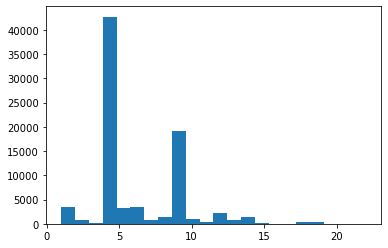

In [11]:
plt.hist(total_events, bins=22)
plt.show()

In [12]:
np_total_events = np.array(total_events)
unique, counts = np.unique(np_total_events, return_counts=True)
dict(zip(unique, counts))

{1: 3486,
 2: 805,
 3: 236,
 4: 42702,
 5: 3307,
 6: 3565,
 7: 750,
 8: 1436,
 9: 19235,
 10: 971,
 11: 324,
 12: 2296,
 13: 808,
 14: 1324,
 15: 110,
 16: 39,
 17: 58,
 18: 384,
 19: 365,
 20: 12,
 21: 14,
 22: 4}

In [13]:
longueur = len(total_events)
print(longueur)
P = 42702/longueur
print(P)

82231
0.5192932105896803


In [14]:
C = dataset.constant_C
print(C)

11836226.803515175


In [15]:
from math import exp

In [16]:
mean_y = y_train.mean()
print(mean_y)

0.045454545454545456


In [17]:
padding_value = 0.123456789
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                              padding='pre',
                                                              value=padding_value,
                                                              dtype='float32')

padded_outputs = tf.keras.preprocessing.sequence.pad_sequences(full_y_train,
                                                              padding='pre',
                                                              value=padding_value,
                                                              dtype='float32')
print(padded_inputs.shape)
print(padded_outputs.shape)

(5306, 735, 24)
(5306, 735, 22)


In [21]:
lstm_units = 50
activation_fn = 'softmax'
loss = 'categorical_crossentropy'

number_of_epochs = 2
history = {}
precision= {}

In [19]:
#LSTMUni

In [20]:
method = 'LSTMUni'
X_train_uni = [[feat[:-2] for feat in x] for x in X_train]
padded_inputs_uni = tf.keras.preprocessing.sequence.pad_sequences(X_train_uni,
                                                              padding='pre',
                                                              value=padding_value,
                                                              dtype='float32')


In [22]:
print('size of input tensor: ',)
print(padded_inputs_uni.shape)
name_of_model = f'{method}-{dt_string}'
regressorLSTMUni = Sequential()
regressorLSTMUni.add(Masking(mask_value=padding_value))
regressorLSTMUni.add(LSTM(units=lstm_units, return_sequences=True))
regressorLSTMUni.add(Dense(units=y_train.shape[1], activation=activation_fn))
regressorLSTMUni.compile(optimizer='adam', loss='categorical_crossentropy')
regressorLSTMUni.fit(padded_inputs_uni, padded_outputs, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 22)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5306 samples
Epoch 1/2
5306/5306 [==============================] - 72s 14ms/sample - loss: 0.2167
Epoch 2/2
5306/5306 [==============================] - 68s 13ms/sample - loss: 0.1801


In [30]:
name_of_model = f'{method}-{dt_string}'
regressorLSTMUni.save(f'saved-models/{name_of_model}.hd5')

INFO:tensorflow:Assets written to: saved-models/LSTMUni-20-02-2020-231259.hd5/assets


In [47]:
X_test_uni = [[feat[:-2] for feat in x] for x in X_test]

In [48]:
padding_value = 0.123456789
padded_inputs_test_uni = tf.keras.preprocessing.sequence.pad_sequences(X_test_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
pred = regressorLSTMUni.predict(padded_inputs_test_uni)


In [68]:
pred = regressorLSTMUni.predict([X_test_uni[0]])
print(pred.shape)
a = np.argmax(pred, axis=2)
print(a)

(1, 57, 22)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [72]:
print(np.argmax(np_full_y_test[0],axis=1))

[10  3  3  3  3  3  3  3  3  3  3  3  8  3  3  3  8  8 11  8  3  3  5 13
  3  8 12  3  8  3  8  3  0  3  3  3  8  3  3  3  3  3  1  3  8  8  3  2
  8  3  8  3  8  3  3  0  3]


In [1]:
correct_pred = 0
total_pred = 0
for x,y in zip(X_test_uni, np_full_y_test):
    total_pred += len(y)
    correct_pred += sum(sum(np.argmax(regressorLSTMUni.predict([x]), axis=2)==np.argmax(y, axis=1)))
print(correct_pred)
print(total_pred)
precision[method] = correct_pred/total_pred

NameError: name 'X_test_uni' is not defined

In [54]:
for pred_, y_ in zip(pred, full_y_test):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-54-390e0e8dfeeb>, line 2)

In [ ]:
prec = 0
for pred_, y_ in zip(pred,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
print(len(pred))
prec /= len(pred)
precision[method] = prec
print(precision)

In [19]:
MSE = {}
mean_sum_of_squares = sum([(y_test[i] - pred[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)

[0.00494943]
{'LSTMUni': 0.0049494293926578585}


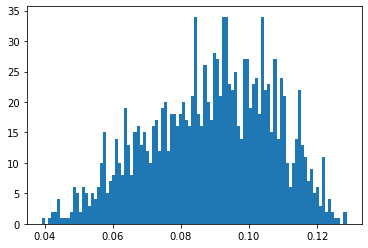

In [20]:
outputs = [pred_[0] for pred_ in pred]
plt.hist(outputs, bins=100)
plt.show()

1327


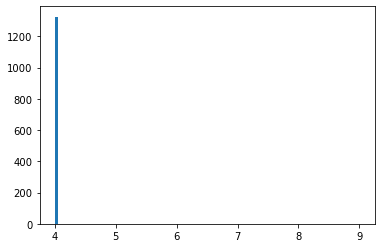

In [88]:
target_val = np.argmax(pred, axis=1) + 1
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

## LSTM Multi

In [86]:
method = 'LSTMMulti'

In [88]:
print('size of input tensor: ',)
print(padded_inputs.shape)
regressorLSTMMulti = Sequential()
regressorLSTMMulti.add(Masking(mask_value=padding_value))
regressorLSTMMulti.add(LSTM(units=lstm_units, return_sequences=True))
regressorLSTMMulti.add(Dense(units=y_train.shape[1], activation=activation_fn))


regressorLSTMMulti.compile(optimizer='adam', loss='categorical_crossentropy')
history[method] = regressorLSTMMulti.fit(padded_inputs, padded_outputs, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 71s 13ms/sample - loss: 0.8453
Epoch 2/20
5306/5306 [==============================] - 68s 13ms/sample - loss: 0.9101
Epoch 3/20
5306/5306 [==============================] - 66s 12ms/sample - loss: 0.9144
Epoch 4/20
5306/5306 [==============================] - 70s 13ms/sample - loss: 0.9093
Epoch 5/20
5306/5306 [==============================] - 87s 16ms/sample - loss: 0.8997
Epoch 6/20
5306/5306 [==============================] - 68s 13ms/sample - loss: 0.9007
Epoch 7/20
5306/5306 [==============================] - 70s 13ms/sample - loss: 0.9008
Epoch 8/20
5306/5306 [==============================] - 76s 14ms/sample - loss: 0.9051
Epoch 9/20
5306/5306 [==============================] - 79s 15ms/sample - loss: 0.8992
Epoch 10/20
5306/5306 [==============================] - 83s 16ms/sample - loss: 0.9041
Epoch 11/20
5306/5306 [==============================] - 78s 15ms/sa

In [90]:
padded_inputs_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
predLSTMMulti = regressorLSTMMulti.predict(padded_inputs_test)


ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 1327, 252, 24]

In [1]:
for x in X_test:
    print(regressorLSTMMulti.predict(np.array([x])))
    break

NameError: name 'X_test' is not defined

In [ ]:
prec = 0
for pred_, y_ in zip(predLSTMMulti,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

[4 4 4 ... 4 4 4]
1327


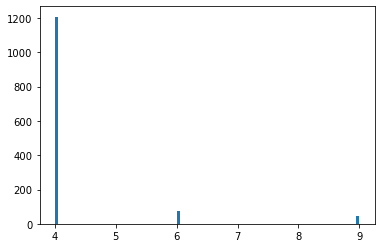

In [92]:
target_val = np.argmax(predLSTMMulti, axis=1)
print(target_val+1)
print(len(target_val))
plt.hist(target_val+1, bins=100)
plt.show()

In [24]:
mean_sum_of_squares = sum([(y_test[i] - predLSTMMulti[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)

[0.00541051]
{'LSTMUni': 0.0049494293926578585, 'LSTMMulti': 0.00541050901253107}


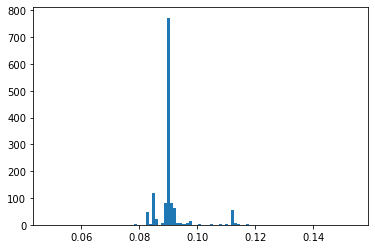

In [25]:
outputs = [pred_[0] for pred_ in predLSTMMulti]
plt.hist(outputs, bins=100)
plt.show()

## T1TimeLSTM

In [26]:
method = 'T1TimeLSTM'

In [27]:
print(padded_inputs.shape)
regressorT1TimeLSTM = Sequential()
regressorT1TimeLSTM.add(Masking(mask_value=padding_value))
regressorT1TimeLSTM.add(T1TimeLSTM(units=lstm_units))
regressorT1TimeLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT1TimeLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT1TimeLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)


(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 92s 17ms/sample - loss: 0.0071
Epoch 2/20
5306/5306 [==============================] - 85s 16ms/sample - loss: 0.0069
Epoch 3/20
5306/5306 [==============================] - 84s 16ms/sample - loss: 0.0069
Epoch 4/20
5306/5306 [==============================] - 83s 16ms/sample - loss: 0.0068
Epoch 5/20
5306/5306 [==============================] - 82s 15ms/sample - loss: 0.0068
Epoch 6/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0068
Epoch 7/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0068
Epoch 8/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0067
Epoch 9/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0066
Epoch 10/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0066
Epoch 11/20
5306/5306 [==============================] - 133s 25ms/sample - loss: 0.0067
Ep

In [28]:
predT1TimeLSTM = regressorT1TimeLSTM.predict(padded_inputs_test)


In [29]:
mean_sum_of_squares = sum([(y_test[i] - predT1TimeLSTM[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)

[0.0049336]
{'LSTMUni': 0.0049494293926578585, 'LSTMMulti': 0.00541050901253107, 'T1TimeLSTM': 0.004933604890250341}


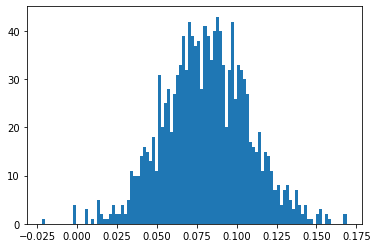

In [30]:
outputs = [pred_[0] for pred_ in predT1TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
prec = 0
for pred_, y_ in zip(predT1TimeLSTM,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

1327


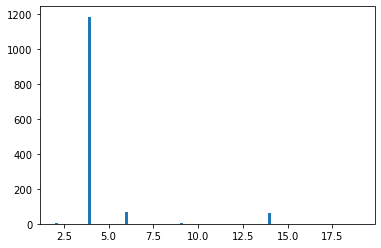

In [106]:
target_val = np.argmax(predT1TimeLSTM, axis=1) + 1
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

In [108]:
unique, counts = np.unique(target_val, return_counts=True)
dict(zip(unique, counts))

{2: 3, 4: 1186, 6: 67, 9: 7, 14: 63, 19: 1}

In [112]:
target_val = np.argmax(y_test, axis=1) + 1
unique, counts = np.unique(target_val, return_counts=True)
dict(zip(unique, counts))


{1: 73,
 2: 14,
 3: 4,
 4: 602,
 5: 93,
 6: 57,
 7: 25,
 9: 376,
 10: 15,
 11: 1,
 12: 13,
 13: 11,
 14: 32,
 15: 3,
 16: 1,
 19: 7}

In [111]:
y_test[:2]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

## T2TimeLSTM

In [31]:
method = 'T2TimeLSTM'
print(padded_inputs.shape)
regressor = Sequential()
regressor.add(Masking(mask_value=padding_value))
regressor.add(T2TimeLSTM(units=lstm_units))
regressor.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)


(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 118s 22ms/sample - loss: 0.0078
Epoch 2/20
5306/5306 [==============================] - 114s 21ms/sample - loss: 0.0070
Epoch 3/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0069
Epoch 4/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0068
Epoch 5/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0068
Epoch 6/20
5306/5306 [==============================] - 105s 20ms/sample - loss: 0.0067
Epoch 7/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0067
Epoch 8/20
5306/5306 [==============================] - 102s 19ms/sample - loss: 0.0067
Epoch 9/20
5306/5306 [==============================] - 104s 20ms/sample - loss: 0.0067
Epoch 10/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0066
Epoch 11/20
5306/5306 [==============================] - 103s 19ms/sample - loss:

In [32]:
predT2TimeLSTM = regressor.predict(padded_inputs_test)


In [33]:
mean_sum_of_squares = sum([(y_test[i] - predT2TimeLSTM[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)


[0.00506469]
{'LSTMUni': 0.0049494293926578585, 'LSTMMulti': 0.00541050901253107, 'T1TimeLSTM': 0.004933604890250341, 'T2TimeLSTM': 0.005064688102638518}


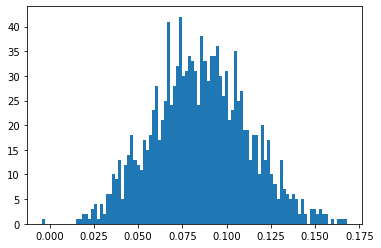

In [34]:
outputs = [pred_[0] for pred_ in predT2TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
prec = 0
for pred_, y_ in zip(predT2TimeLSTM,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

In [16]:
target_val = np.argmax(predT2TimeLSTM, axis=1)
print(target_val+1)
print(len(target_val))
plt.hist(target_val+1, bins=100)
plt.show()

NameError: name 'predT2TimeLSTM' is not defined

## TimeDepJointEmbedding

In [35]:
method = 'TimeDepJointEmbedding'
print(padded_inputs.shape)
regressor = Sequential()
regressor.add(Masking(mask_value=padding_value))
regressor.add(TimeDepJointEmbedding(units=lstm_units))
regressor.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0079
Epoch 2/20
5306/5306 [==============================] - 99s 19ms/sample - loss: 0.0073
Epoch 3/20
5306/5306 [==============================] - 98s 18ms/sample - loss: 0.0071
Epoch 4/20
5306/5306 [==============================] - 97s 18ms/sample - loss: 0.0070
Epoch 5/20
5306/5306 [==============================] - 90s 17ms/sample - loss: 0.0069
Epoch 6/20
5306/5306 [==============================] - 90s 17ms/sample - loss: 0.0068
Epoch 7/20
5306/5306 [==============================] - 92s 17ms/sample - loss: 0.0068
Epoch 8/20
5306/5306 [==============================] - 91s 17ms/sample - loss: 0.0067
Epoch 9/20
5306/5306 [==============================] - 91s 17ms/sample - loss: 0.0068
Epoch 10/20
5306/5306 [==============================] - 91s 17ms/sample - loss: 0.0067
Epoch 11/20
5306/5306 [==============================] - 169s 32ms/sample - loss: 0.0067
E

In [36]:
predTimeDep = regressor.predict(padded_inputs_test)


In [37]:
mean_sum_of_squares = sum([(y_test[i] - predTimeDep[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)


[0.00495521]
{'LSTMUni': 0.0049494293926578585, 'LSTMMulti': 0.00541050901253107, 'T1TimeLSTM': 0.004933604890250341, 'T2TimeLSTM': 0.005064688102638518, 'TimeDepJointEmbedding': 0.004955211572976857}


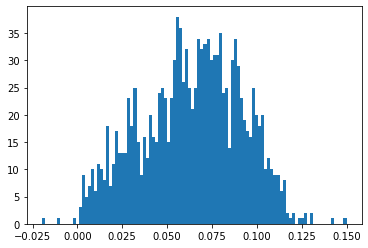

In [39]:
outputs = [pred_[0] for pred_ in predTimeDep]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
prec = 0
for pred_, y_ in zip(predTimeDep,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

[ 4  4  4 ...  6  4 14]
1327


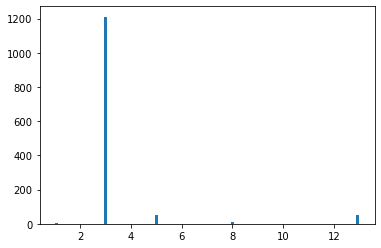

In [102]:
target_val = np.argmax(predTimeDep, axis=1)
print(target_val+1)
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

In [103]:
from matplotlib import pyplot as plt

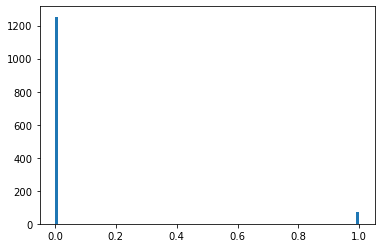

In [104]:
target_values = [val[0] for val in y_test]
plt.hist(target_values, bins=100)
plt.show()

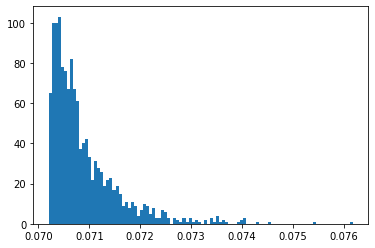

In [105]:
target_values = [val[0] for val in pred]
plt.hist(target_values, bins=100)
plt.show()

In [40]:
average_target = y_train.mean()
print(average_target)

0.08818682350418736


In [41]:
MSE = sum([(average_target - y_test_val[0])**2 for y_test_val in y_test])/len(y_test)
print(MSE)

0.0052225623690812795


In [ ]:
print(MSE)

In [ ]:
print(dataset.next_event[:10])

KeyboardInterrupt: 

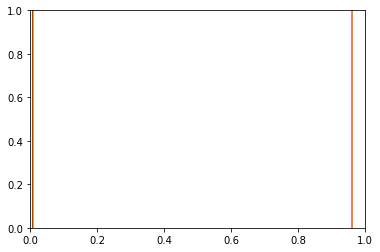

In [138]:
plt.hist(dataset.next_event, bins=22)
plt.show()

In [152]:
dataset_name = dataset_names[0]
pickle_filename = dataset_name.replace('/', '-')
if os.path.exists(pickle_filename):
    print('Reading pickle file...')
    dataset = pickle.load(open(pickle_filename, 'rb'))

Reading pickle file...


In [143]:
A = np.array(dataset.next_event)

In [147]:
B = np.array([np.argmax(a) for a in A]) + 1

In [148]:
B[:10]

array([4, 5, 2, 4, 5, 6, 4, 6, 9, 4])

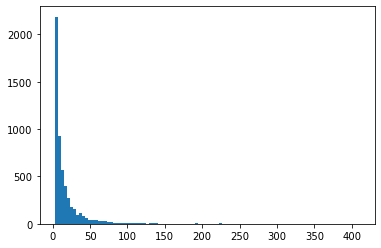

In [155]:
plt.hist(dataset.full_seqlen, bins=100)
plt.show()

In [160]:
seqlen = np.array(dataset.full_seqlen)
print(max(seqlen))
print(min(seqlen))
print(len(seqlen))

410
3
5468


No handles with labels found to put in legend.


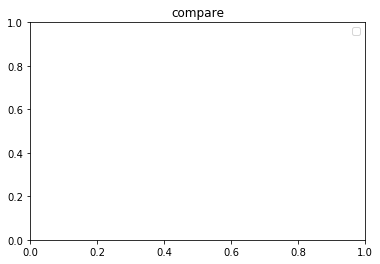

In [156]:
x = [0.00001,0.001,0.01,0.1,0.5,1,5]
# create an index for each tick position


plt.title('compare')
plt.legend() 
plt.show()